# 1. Sleep well (35 points)

In [1]:
import pandas as pd

# Load the data
X_train = pd.read_csv('data\Sleep-EDF-15_U-Time/X_train.csv', header=None)
y_train = pd.read_csv('data\Sleep-EDF-15_U-Time/y_train.csv', header=None)
X_test = pd.read_csv('data\Sleep-EDF-15_U-Time/X_test.csv', header=None)
y_test = pd.read_csv('data\Sleep-EDF-15_U-Time/y_test.csv', header=None)

## 1.1 Data understanding and preprocessing

Class frequencies for training data:
Class (0.0,): 52.09%
Class (1.0,): 9.55%
Class (2.0,): 25.27%
Class (3.0,): 4.69%
Class (4.0,): 8.39%


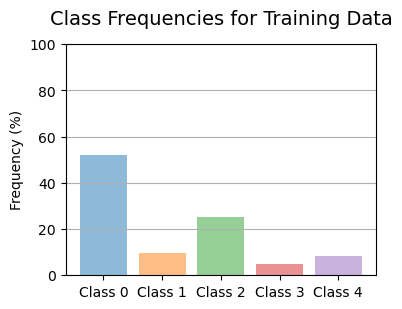

In [57]:
import matplotlib.pyplot as plt

# Calculate class frequencies for training data, normalized to [0,1]
class_frequencies = y_train.value_counts(normalize=True).sort_index()

# Print each class frequency for training data
print("Class frequencies for training data:")
for label, freq in class_frequencies.items():
    print(f"Class {label}: {freq*100:.2f}%")

# Plotting
labels = [f"Class {i}" for i in range(0, 5)]
freqs = class_frequencies.values * 100

plt.figure(figsize=(4, 3))
plt.bar(labels, freqs, color=plt.cm.tab10.colors, alpha=0.5)
plt.ylabel('Frequency (%)')
plt.title('Class Frequencies for Training Data', fontsize=14, y=1.05)
plt.ylim(0, 100)
plt.grid(axis='y')

plt.savefig('output/class_frequencies.png')
plt.show()

## 1.2 Classification

### Method to evaluate the models

In [3]:
from sklearn.metrics import classification_report, accuracy_score, zero_one_loss

def evaluate_classifier(cv_results, y_true_train, y_best_pred_train, y_true_test, y_best_pred_test, classifier_name):
    train_accuracy = accuracy_score(y_true_train, y_best_pred_train)
    train_report = classification_report(y_true_train, y_best_pred_train)

    test_accuracy = accuracy_score(y_true_test, y_best_pred_test)
    test_report = classification_report(y_true_test, y_best_pred_test)

    print(f"\nEvaluation Metrics for {classifier_name}:\n")

    print(f"(Best) Train Accuracy: {train_accuracy:.2f}")
    print(f"(Best) Train Error: {zero_one_loss(y_true_train, y_best_pred_train):.2f}")
    print(f"(Best) Train Classification Report:\n{train_report}")

    print(f"(Best) Test Accuracy: {test_accuracy:.2f}")
    print(f"(Best) Test Error: {zero_one_loss(y_true_test, y_best_pred_test):.2f}")
    print(f"(Best) Test Classification Report:\n{test_report}")

    # Get all the results
    print("-" * 50)
    print("\nAll results:")
    for i in range(len(cv_results['params'])):
        print(f"Combination {i+1}:")
        print("Parameters:", cv_results['params'][i])
        print("Mean Training Score:", cv_results['mean_train_score'][i])
        print("Mean Test Score (Validation Score):", cv_results['mean_test_score'][i])
        print("-" * 50)

### Multi-nominal Logistic Regression

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
lr_param = {
    'C': [0.0001, 0.001, 0.01, 0.1]
}

# Grid search
lr_grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=10000, n_jobs=-1),
                           param_grid=lr_param,
                           n_jobs=-1,
                           cv=5,
                           return_train_score=True)
lr_grid_search.fit(X_train, y_train.values.ravel())

lr_best_model = lr_grid_search.best_estimator_

# Print best hyperparameters
print("Best Hyperparameters:", lr_grid_search.best_params_)

# Predict and evaluate using the best model
lr_best_train_pred = lr_best_model.predict(X_train)
lr_best_test_pred = lr_best_model.predict(X_test)

# Evaluate the model
evaluate_classifier(lr_grid_search.cv_results_, y_train, lr_best_train_pred, y_test, lr_best_test_pred, f"Logistic Regression (Best Model)")

Best Hyperparameters: {'C': 0.001}

Evaluation Metrics for Logistic Regression (Best Model):

(Best) Train Accuracy: 0.84
(Best) Train Error: 0.16
(Best) Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     17566
         1.0       0.54      0.37      0.44      3221
         2.0       0.76      0.85      0.81      8523
         3.0       0.70      0.57      0.63      1583
         4.0       0.71      0.73      0.72      2831

    accuracy                           0.84     33724
   macro avg       0.74      0.70      0.71     33724
weighted avg       0.84      0.84      0.84     33724

(Best) Test Accuracy: 0.90
(Best) Test Error: 0.10
(Best) Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7579
         1.0       0.47      0.52      0.49       775
         2.0       0.90      0.89      0.89      3841
         3.0       0.72  

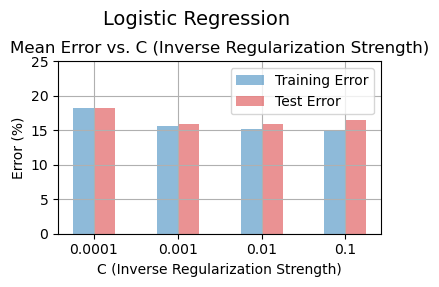

In [55]:
# Plotting cross-validation results
lr_mean_train_scores = lr_grid_search.cv_results_['mean_train_score']
lr_mean_test_scores = lr_grid_search.cv_results_['mean_test_score']

# Bar chart settings
index = np.arange(len(lr_param['C']))
bar_width = 0.25

plt.figure(figsize=(4, 3))
plt.bar(index, 100-lr_mean_train_scores*100, bar_width, label='Training Error', color='tab:blue', alpha=0.5)
plt.bar(index + bar_width, 100-lr_mean_test_scores*100, bar_width, label='Test Error', color='tab:red', alpha=0.5)

# Set the x-tick positions and labels
tick_positions = index + bar_width/2
plt.xticks(tick_positions, lr_param['C'])

plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Error (%)')
plt.ylim(0, 25)
plt.suptitle('Logistic Regression', fontsize=14, y=0.94)
plt.title('Mean Error vs. C (Inverse Regularization Strength)')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

### Random Forests

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Hyperparameter tuning
rf_param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Grid search
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), 
                           param_grid=rf_param, 
                           n_jobs=-1, 
                           cv=5,
                           verbose=3,
                           return_train_score=True)
rf_grid_search.fit(X_train, y_train.values.ravel())

# Get the best estimator (model)
rf_best_model = rf_grid_search.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters:", rf_grid_search.best_params_)

# Predict and evaluate using the best model
rf_best_train_pred = rf_best_model.predict(X_train)
rf_best_test_pred = rf_best_model.predict(X_test)

# Evaluate the model
evaluate_classifier(rf_grid_search.cv_results_, y_train, rf_best_train_pred, y_test, rf_best_test_pred, f"Random Forest (Best Model)")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

Evaluation Metrics for Random Forest (Best Model):

(Best) Train Accuracy: 0.89
(Best) Train Error: 0.11
(Best) Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     17566
         1.0       0.71      0.55      0.62      3221
         2.0       0.81      0.89      0.85      8523
         3.0       0.86      0.57      0.69      1583
         4.0       0.76      0.83      0.79      2831

    accuracy                           0.89     33724
   macro avg       0.82      0.77      0.79     33724
weighted avg       0.88      0.89      0.88     33724

(Best) Test Accuracy: 0.90
(Best) Test Error: 0.10
(Best) Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.9

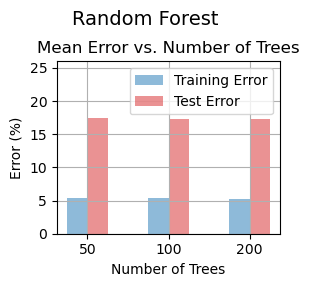

In [54]:
# Calculate the mean errors for each n_estimators value
unique_n_estimators = rf_param['n_estimators']
rf_mean_train_errors = []
rf_mean_test_errors = []

for n in unique_n_estimators:
    indices = [i for i, est in enumerate(rf_grid_search.cv_results_['param_n_estimators']) if est == n]
    rf_mean_train_errors.append(np.mean([100 - 100*rf_grid_search.cv_results_['mean_train_score'][i] for i in indices]))
    rf_mean_test_errors.append(np.mean([100 - 100*rf_grid_search.cv_results_['mean_test_score'][i] for i in indices]))

# Bar chart settings
index = np.arange(len(unique_n_estimators))
bar_width = 0.25

plt.figure(figsize=(3, 3))
plt.bar(index, rf_mean_train_errors, bar_width, label='Training Error', color='tab:blue', alpha=0.5)
plt.bar(index + bar_width, rf_mean_test_errors, bar_width, label='Test Error', color='tab:red', alpha=0.5)

# Set the x-tick positions and labels
tick_positions = index + bar_width/2
plt.xticks(tick_positions, unique_n_estimators)

plt.xlabel('Number of Trees')
plt.ylabel('Error (%)')
plt.ylim(0, 26)
plt.suptitle('Random Forest', fontsize=14, y=0.94)
plt.title('Mean Error vs. Number of Trees')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

### k-Nearest-Neighbor Classification

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
# Rule of thumb: sqrt(n) where n is the number of samples: https://quantdev.ssri.psu.edu/sites/qdev/files/kNN_tutorial.html
# 4 set in the training dataset and 1 set for validation. Total samples: 33724; validation samples: 33724/5 = 6745; training samples: 33724 - 6745 = 26979
# K-neighbors should be an odd value in KNN to avoid ties at decision boundaries
# where majority voting occurs. Using odd numbers helps prevent ties.
knn_param = {'n_neighbors': range(1, 130, 2)}  # Considering odd values from 1 to 129 neighbors

# Grid Search to find the best number of neighbors
knn_grid_search = GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1),
                           param_grid=knn_param,
                           return_train_score=True,
                           n_jobs=-1,
                           cv=5)
knn_grid_search.fit(X_train, y_train.values.ravel())

# Train the model with the best number of neighbors
knn_best_model = knn_grid_search.best_estimator_

# Predict and evaluate using the best model
knn_best_train_pred = knn_best_model.predict(X_train)
knn_best_test_pred = knn_best_model.predict(X_test)

# Print the best parameters
print("Best parameters:", knn_grid_search.best_params_)

# Evaluate the model
evaluate_classifier(knn_grid_search.cv_results_, y_train, knn_best_train_pred, y_test, knn_best_test_pred, "K-Nearest Neighbors")

Best parameters: {'n_neighbors': 105}

Evaluation Metrics for K-Nearest Neighbors:

(Best) Train Accuracy: 0.85
(Best) Train Error: 0.15
(Best) Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     17566
         1.0       0.57      0.43      0.49      3221
         2.0       0.78      0.85      0.81      8523
         3.0       0.76      0.53      0.62      1583
         4.0       0.70      0.78      0.74      2831

    accuracy                           0.85     33724
   macro avg       0.75      0.71      0.73     33724
weighted avg       0.85      0.85      0.85     33724

(Best) Test Accuracy: 0.90
(Best) Test Error: 0.10
(Best) Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7579
         1.0       0.47      0.53      0.50       775
         2.0       0.90      0.88      0.89      3841
         3.0       0.76      0.65  

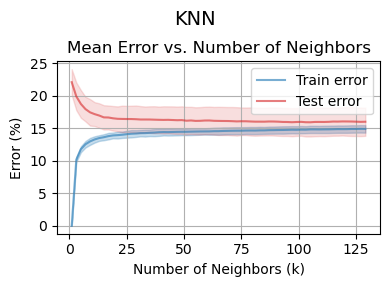

In [51]:
# Plot the cross-validation results
k_values = np.array(knn_grid_search.cv_results_['param_n_neighbors'].data, dtype=float)
train_error = np.array(100 - knn_grid_search.cv_results_['mean_train_score']*100, dtype=float)
test_error = np.array(100 - knn_grid_search.cv_results_['mean_test_score']*100, dtype=float)
train_std = np.array(knn_grid_search.cv_results_['std_train_score']*100, dtype=float)
test_std = np.array(knn_grid_search.cv_results_['std_test_score']*100, dtype=float)

plt.figure(figsize=(4, 3))
plt.plot(k_values, train_error, label="Train error", color="tab:blue", alpha=0.6)
plt.fill_between(k_values, train_error - train_std, train_error + train_std, color="tab:blue", alpha=0.25)  # Variance for train error
plt.plot(k_values, test_error, label='Test error', color="tab:red", alpha=0.6)
plt.fill_between(k_values, test_error - test_std, test_error + test_std, color="tab:red", alpha=0.15)  # Variance for test error

plt.suptitle('KNN', fontsize=14, y=0.94)
plt.title('Mean Error vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('output/knn.png')
plt.show()

# 2. Invariance and normalization (30 points)

Mean of age: 34.5
Mean of income: 37.5

Centered coordinates for Mr. Good: [12.5 -2.5]
Centered coordinates for Mr. Bad: [-12.5   2.5]
Centered coordinates for Mr. Unknown: [-13.5  -1.5]

Variance of age: 156.25
Variance of income: 6.25

Standard deviation of age: 12.5
Standard deviation of income: 2.5

Normalized coordinates for Mr. Good: [1.0, -1.0]
Normalized coordinates for Mr. Bad: [-1.0, 1.0]
Normalized coordinates for Mr. Unknown: [-1.08, -0.6]


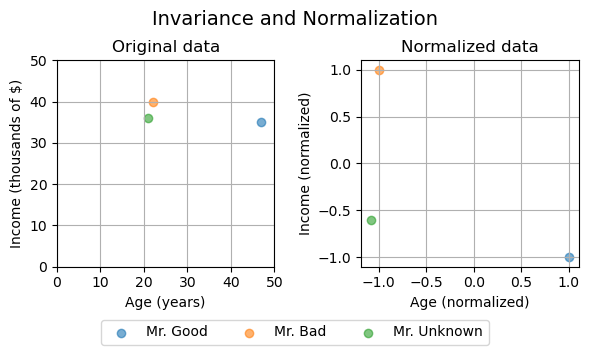

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Original data
data = {
    "Mr. Good":     np.array([47, 35]),
    "Mr. Bad":      np.array([22, 40]),
    "Mr. Unknown":  np.array([21, 36])
}

# Calculate means
mean_x = np.mean([data["Mr. Good"][0], data["Mr. Bad"][0]])
mean_y = np.mean([data["Mr. Good"][1], data["Mr. Bad"][1]])

print(f"Mean of age: {mean_x}")
print(f"Mean of income: {mean_y}\n")

# Center the data (zero mean)
centered_data = {key: value - [mean_x, mean_y] for key, value in data.items()}

for key, value in centered_data.items():
    print(f"Centered coordinates for {key}: {value}")

# Calculate variances
var_x = np.var([centered_data["Mr. Good"][0], centered_data["Mr. Bad"][0]])
var_y = np.var([centered_data["Mr. Good"][1], centered_data["Mr. Bad"][1]])

print(f"\nVariance of age: {var_x}")
print(f"Variance of income: {var_y}")

# Calculate standard deviations
std_x = np.sqrt(var_x)
std_y = np.sqrt(var_y)

print(f"\nStandard deviation of age: {std_x}")
print(f"Standard deviation of income: {std_y}\n")

# Normalize the data (variance one)
normalized_data = {key: [value[0]/std_x, value[1]/std_y] for key, value in centered_data.items()}

for key, value in normalized_data.items():
    print(f"Normalized coordinates for {key}: {value}")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Original data plot
for key, value in data.items():
    ax[0].scatter(value[0], value[1], label=key, alpha=0.6)
ax[0].set_title("Original data")
ax[0].set_xlabel("Age (years)")
ax[0].set_ylabel("Income (thousands of $)")
ax[0].grid(True)
ax[0].set_xlim(0, 50)
ax[0].set_ylim(0, 50)

# Normalized data plot
for key, value in normalized_data.items():
    ax[1].scatter(value[0], value[1], label=key, alpha=0.6)
ax[1].set_title("Normalized data")
ax[1].set_xlabel("Age (normalized)")
ax[1].set_ylabel("Income (normalized)")
ax[1].grid(True)

# Add a single legend for the entire figure
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), ncol=3)

plt.tight_layout()
plt.suptitle("Invariance and Normalization", fontsize=14, y=1.05)
plt.savefig('output/invariance_and_normalization.png')
plt.show()

# 3. Differentiable programming (35 points)

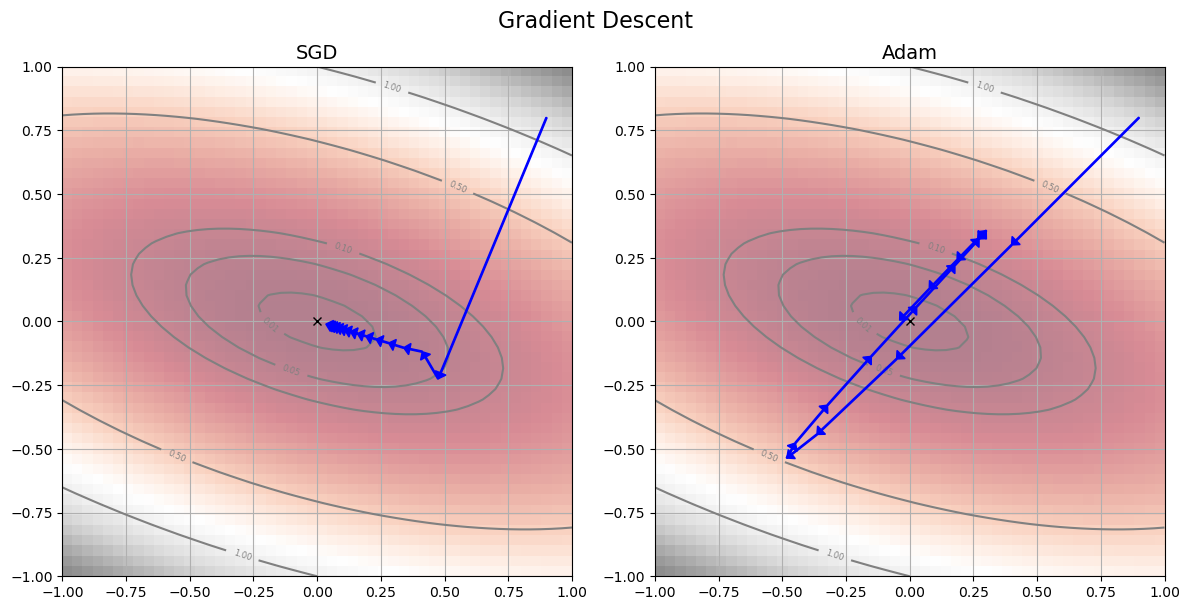

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Parameter affecting the shape of the quadratic function
p_f = 0.5  

# Quadratic function definition
def f(x, y):
    """Compute the value of the function for given x and y."""
    return (p_f*x)**2 + y**2 + p_f*x*y

def gradient_descent_plot(optimizer_type, p_x, p_y, r, n_iter, ax):
    """
    Plot the contour of the function and the gradient descent path on the given axis.
    
    Parameters:
    - p_x, p_y: Lists containing x and y coordinates of the gradient descent path.
    - r: Range for plotting.
    - n_iter: Number of iterations.
    - ax: Axis on which to plot.
    """

    # Generate meshgrid for contour plot
    x = np.linspace(-r, r, 50)
    y = np.linspace(-r, r, 50)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # Draw contour lines and fill on the given axis
    contours = ax.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.5, 1.], colors='grey')
    ax.clabel(contours, inline=True, fontsize=6)
    ax.imshow(Z, extent=[-r, r, -r, r], origin='lower', cmap='RdGy', alpha=0.5)

    # Mark the optimum point on the given axis
    ax.plot(0, 0, 'x', c='k')

    # Plot arrows showing the gradient descent path on the given axis
    for i in range(n_iter):
        ax.arrow(p_x[i], p_y[i], p_x[i+1]-p_x[i], p_y[i+1]-p_y[i], width=.005, head_width=.045, head_length=.025, length_includes_head=True, fc='b', ec='b', zorder=10)
    
    # Set title for the given axis
    ax.set_title(f'{optimizer_type}', fontsize=14)
    ax.grid(True)

def perform_gradient_descent(optimizer_type, eta, n_iter, r, ax):
    """
    Perform gradient descent optimization and store the path.
    
    Parameters:
    - optimizer_type: Type of optimizer to use ("SGD" or "Adam").
    - eta: Learning rate.
    - n_iter: Number of iterations.
    - r: Range for initial point.
    """
    # Initialize starting point
    x = torch.ones(1, requires_grad=True)
    y = torch.ones(1, requires_grad=True)
    with torch.no_grad():
        x *= 0.9*r
        y *= 0.8*r

    # Lists to store path of gradient descent
    p_x = [x.item()]
    p_y = [y.item()]

    # Choose optimizer based on input
    if optimizer_type == "SGD":
        optimizer = torch.optim.SGD([x, y], lr=eta)
    elif optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x, y], lr=eta)
    else:
        raise ValueError("Unsupported optimizer type")

    # Gradient descent loop
    for i in range(n_iter):
        optimizer.zero_grad()
        f(x, y).backward()
        optimizer.step()
        p_x.append(x.item())
        p_y.append(y.item())

    # Plot the results of gradient descent
    gradient_descent_plot(optimizer_type, p_x, p_y, r, n_iter, ax)

# Range for plotting the function
r = 1.

# Create a single figure with two subplots for SGD and Adam
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Perform and plot gradient descent using SGD optimizer on the first subplot
perform_gradient_descent("SGD", eta = 0.5, n_iter = 15, r = r, ax=ax1)

# Perform and plot gradient descent using Adam optimizer on the second subplot
perform_gradient_descent("Adam", eta = 0.5, n_iter = 15, r = r, ax=ax2)

# Adjust layout and show the combined plot
plt.tight_layout()
plt.suptitle('Gradient Descent', fontsize=16, y=1.02)
plt.savefig('output/gradient_descent_side_by_side.png')
plt.show()